<a href="https://colab.research.google.com/github/Raph3103/hw1up/blob/master/Copie_de_Low_Collateral_Blockchain_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low Collateral Blockchain Project


In [61]:
pip install pandas

In [62]:
import pandas as pd
import pickle

Get the stat file: We will start by obtaining the stat file, which contains relevant data for our analysis.

In [63]:
data = pd.read_pickle('/content/HistoryPoolBorrowersStats.pkl')

df = pd.DataFrame.from_dict(data,orient='index')

chemin_fichier_csv = 'newStats.csv'

df.to_csv(chemin_fichier_csv, index=True)


Add columns and modify the existing file: We will enhance the stat file by adding new columns and modifying existing ones to better suit our analysis requirements.


In [64]:

df = pd.read_csv('newStats.csv')


columns_to_remove = ['datesSupplyCollateral', 'datesLoan','datesReimbursement','datesWithdrawCollateral','timeUTCFirstAnyTransactionAccount','borrowerAgeInYears','totalLoans','NumLoans','MeanLoans','totalTimeloans','MeanTimeLoans','totalSupplyCollateral','NumSupplyCollateral','MeanSupplyCollateral','totalReimbursements','NumReimbursements','MeanReimbursements','NumTransactions']  # Specify the names of the columns to remove
df = df.drop(columns=columns_to_remove)



df.to_csv('newStats.csv', index=False)

This part transfor the dict from date keys to tomestamps keys and also add a new value named ratio for each timestamsp if size debt = 0 then collateralDebtRatio = infinity

In [65]:
import pandas as pd
import json
from datetime import datetime
import time

df = pd.read_csv('newStats.csv')



def date_to_timestamp(date_str):
    dt_object = datetime.strptime(date_str, "%Y-%m-%d")
    timestamp = int(time.mktime(dt_object.timetuple()))
    return timestamp


for i, cell in enumerate(df['Calendar']):
    if isinstance(cell, str):
        cell = cell.replace("'", '"')
        calendar_dict = json.loads(cell)
        new_calendar_dict = {}
        for date_str, day_dict in calendar_dict.items():
            timestamp = date_to_timestamp(date_str)
            if day_dict['sizeDebtUSD'] != 0:
                ratio = day_dict['sizeCollateralUSD'] / day_dict['sizeDebtUSD']
            else:
                ratio = float('inf')
            day_dict['collateralDebtRatio'] = ratio

            new_calendar_dict[timestamp] = day_dict
        df.at[i, 'Calendar'] = json.dumps(new_calendar_dict)
    else:
        continue
df.to_csv('newStats.csv', index=False)


adding most frequent time in the day

In [66]:
import pandas as pd
from datetime import datetime

def timestamp_to_category(timestamp):
    dt_object = datetime.fromtimestamp(int(float(timestamp)))
    hour = dt_object.hour
    if 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 24:
        return "Evening"
    else:
        return "Night"

def most_frequent_category(lst):
    return max(set(lst), key=lst.count) if lst else None

df = pd.read_csv('newStats.csv')
timestamp_cols = ['timeStampsSupplyCollateral', 'timeStampsLoans', 'timeStampsReimbursement', 'timeStampsWithdrawCollateral', 'timeStampFirstAnyTransactionAccount']
df['MostFrequentTransactionTimeOfDay'] = ""
for i, row in df.iterrows():
    categories = []
    for col in timestamp_cols:
        if pd.isnull(row[col]):
            continue
        timestamps = str(row[col]).split()
        for timestamp in timestamps:
            categories.append(timestamp_to_category(timestamp))
    df.at[i, 'MostFrequentTransactionTimeOfDay'] = most_frequent_category(categories)
df.to_csv('newStats.csv', index=False)


count the number of days with high ratio(1 but we can change the value if needed) for each user, using the new value in the calendar colomn

In [67]:
import json

threshold = 2.2

def count_days_with_high_ratio(calendar_str):
    if not isinstance(calendar_str, str):
        return None
    calendar = json.loads(calendar_str)

    count = 0
    for day, attributes in calendar.items():
        if 'collateralDebtRatio' in attributes and attributes['collateralDebtRatio'] > threshold:
            count += 1
    return count
df['DaysWithHighRatio'] = df['Calendar'].apply(count_days_with_high_ratio)
df.to_csv('newStats.csv', index=False)

if the user paid x percent in the last y month the val is true

In [68]:
import json
import time

x_percent=0.1

y_month=9
def loan_repaid_x_percent_in_last_y_months(calendar):
    six_months_ago = 1668297600 - y_month*30*24*60*60
    if isinstance(calendar, str):
        calendar_dict = json.loads(calendar)
    else:
        return False
    total_loan = 0
    total_repayment = 0
    for timestamp, day_dict in calendar_dict.items():
        timestamp = int(timestamp)
        if six_months_ago <= timestamp <= 1668297600:
            total_loan += day_dict['sizeDebtUSD']
            total_repayment += day_dict['amountPaymentsOnDay']
    if total_loan == 0:
        return False
    repayment_percentage = total_repayment / total_loan
    if repayment_percentage >= x_percent:
        return True
    else:
        return False
df['LoanRepaidxPercentInLastyMonths'] = df['Calendar'].apply(loan_repaid_x_percent_in_last_y_months)
df.to_csv('newStats.csv', index=False)

Create a function to evaluate user behavior: We will develop a function that determines whether a user is classified as good or bad based on their activities on our platform. This function will help us assess user behavior and identify potential risks.


In [69]:
from datetime import datetime, timedelta

today = datetime.now()

six_months_ago = today - timedelta(days=15*30)
timestamp_today = int(today.timestamp())
timestamp_six_months_ago = int(six_months_ago.timestamp())


def evaluate_user_behavior(row):
    conditions_met = 0


    if row['DaysWithHighRatio'] > 60:
        conditions_met += 2
        if row['LoanRepaidxPercentInLastyMonths']:
          conditions_met += 4
    if row['timeStampFirstAnyTransactionAccount'] < timestamp_six_months_ago :
        conditions_met += 1

    if conditions_met==5 or conditions_met == 6 or conditions_met==7 or conditions_met == 3:
        return 'Good'
    elif conditions_met ==0 :
        return 'Bad'
    else:
        return 'Unknown'


Run the function for all rows: We will iterate over each row of the stat file and apply the user evaluation function to determine the classification for each user.


In [70]:
df['user_class'] = df.apply(evaluate_user_behavior, axis=1)

Add the new column to the CSV: After evaluating all the users, we will add the newly generated classification column to the CSV file.


In [71]:
import pandas as pd

df = df.drop(columns='Calendar')
df.to_csv('updated_data.csv', index=False)

Run a machine learning model: With the updated CSV file, we will utilize a machine learning model to gain insights and predictions based on the user behavior data.


In [72]:
def user_class_distribution(data: pd.DataFrame):
    label_counts = data["user_class"].value_counts().reset_index()
    label_counts.columns = ['Rating', 'Count']
    label_counts['Rating'] = label_counts['Rating'].map({0: 'Bad', 1: 'Good', 2: 'Unknown'})
    fig = px.bar(
        label_counts,
        x='Rating',
        y='Count',
        title='Label Distribution',
        labels={'Rating': 'user_class', 'Count': 'Count'},
        color='Rating',  # Apply colors to each category
        color_discrete_map={'Bad': 'blue', 'Good': 'green', 'Unknown': 'orange',},  # Specify colors
    )

    # Customize layout and appearance
    fig.update_layout(
        xaxis_title="user_class",
        yaxis_title="Count",
        legend_title="Label Category",
        font=dict(size=12),
    )

    fig.show()

In [73]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('updated_data.csv')
#print(df.describe())
df = df.drop(columns=['Unnamed: 0'])
#df = df.drop(columns=['Calendar'])
for col in ['timeStampsSupplyCollateral', 'timeStampsLoans', 'timeStampsReimbursement', 'timeStampsWithdrawCollateral','maximumDebt', 'atTimeMaximumDebtCollateralProvided']:
    df= df.drop(columns=col)

rows_with_nan = df[df.isna().any(axis=1)]

df.dropna()
df['LoanRepaidxPercentInLastyMonths'] = df['LoanRepaidxPercentInLastyMonths'].astype(int)
le = preprocessing.LabelEncoder()
print(df.head())
df['MostFrequentTransactionTimeOfDay'] = le.fit_transform(df['MostFrequentTransactionTimeOfDay'])
print(df.head())
df['user_class'] = le.fit_transform(df['user_class'])
#print(df.describe())
scaler = StandardScaler()
num_cols = ['sizeLoansUSD', 'sizeCollateralUSD', 'sizeReimbursementsUSD', 'numLoansUser', 'ratioCollateralToLoans', 'averageOfDailyCollateralToDebt', 'numTransactionsUser', 'DaysWithHighRatio']
df[num_cols] = scaler.fit_transform(df[num_cols])
for cols in ['DaysWithHighRatio','timeStampFirstAnyTransactionAccount','LoanRepaidxPercentInLastyMonths']:
  df = df.drop(columns=cols)
X = df.drop('user_class', axis=1)
y = df['user_class']

#print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = X_train.dropna()
y_train = y_train[X_train.index]

    sizeLoansUSD  sizeCollateralUSD  sizeReimbursementsUSD  numLoansUser  \
0   20000.062400       38882.100000           20000.136403           1.0   
1     906.374472         896.913597             400.001248           2.0   
2    2200.006864        4147.424000             493.921711           1.0   
3  120000.374400      184222.316475          120000.383553           1.0   
4    9868.016127       20252.865722            9910.467632           6.0   

   numReimbursementsUser  ratioCollateralToLoans  \
0                    1.0                1.944099   
1                    1.0                0.989562   
2                    1.0                1.885187   
3                    1.0                1.535181   
4                    2.0                2.052375   

   averageOfDailyCollateralToDebt  numTransactionsUser  \
0                        1.000000                 10.0   
1                        1.755201                  4.0   
2                        2.051919                  4.0  

Printing informations
ypred: [2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2]


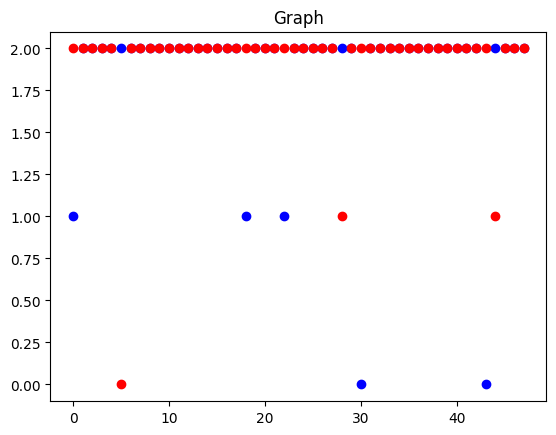

Accuracy: 0.8333333333333334


In [74]:

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print('Printing informations')
print( 'ypred:', (y_pred))
#print( 'y_train:', y_train)
#print( 'X_test:', X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
df__ = pd.DataFrame(X_test)
df__.to_csv('mon_fichier.csv', index=False)

In [75]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'n_neighbors': [3],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2],
}
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Meilleurs paramètres : {best_params}")
print(f'Accuracy avec meilleurs paramètres: {accuracy}')
print('Classification Report avec meilleurs paramètres:\n', report)


Meilleurs paramètres : {'algorithm': 'auto', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Accuracy avec meilleurs paramètres: 0.8333333333333334
Classification Report avec meilleurs paramètres:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.89      0.93      0.91        43

    accuracy                           0.83        48
   macro avg       0.30      0.31      0.30        48
weighted avg       0.80      0.83      0.81        48



In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np

rfc = RandomForestClassifier( n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         3
           2       0.91      0.98      0.94        43

    accuracy                           0.90        48
   macro avg       0.47      0.49      0.48        48
weighted avg       0.84      0.90      0.87        48



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Analyze performance: Finally, we will analyze the performance of our machine learning model and evaluate its effectiveness in predicting user behavior accurately.

In [77]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Meilleurs paramètres : {best_params}")
print(f'Accuracy avec meilleurs paramètres: {accuracy}')
print('Classification Report avec meilleurs paramètres:\n', report)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Meilleurs paramètres : {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy avec meilleurs paramètres: 0.8541666666666666
Classification Report avec meilleurs paramètres:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         3
           2       0.91      0.93      0.92        43

    accuracy                           0.85        48
   macro avg       0.47      0.48      0.47        48
weighted avg       0.84      0.85      0.84        48



In [78]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Accuracy: 0.8958333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.90      1.00      0.95        43

    accuracy                           0.90        48
   macro avg       0.30      0.33      0.32        48
weighted avg       0.80      0.90      0.85        48



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

logistic_regression = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_


best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Meilleurs paramètres : {best_params}")
print(f'Accuracy avec meilleurs paramètres: {accuracy}')
print('Classification Report avec meilleurs paramètres:\n', report)

Meilleurs paramètres : {'C': 0.001, 'penalty': 'l2'}
Accuracy avec meilleurs paramètres: 0.8958333333333334
Classification Report avec meilleurs paramètres:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.90      1.00      0.95        43

    accuracy                           0.90        48
   macro avg       0.30      0.33      0.32        48
weighted avg       0.80      0.90      0.85        48



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

model = SVC(kernel='linear', C=1.0, decision_function_shape='ovr')

model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Accuracy: 0.8958333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.90      1.00      0.95        43

    accuracy                           0.90        48
   macro avg       0.30      0.33      0.32        48
weighted avg       0.80      0.90      0.85        48



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
}

svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Meilleurs paramètres : {best_params}")
print(f'Accuracy avec meilleurs paramètres: {accuracy}')
print('Classification Report avec meilleurs paramètres:\n', report)

Meilleurs paramètres : {'C': 0.1, 'degree': 2, 'kernel': 'linear'}
Accuracy avec meilleurs paramètres: 0.8958333333333334
Classification Report avec meilleurs paramètres:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.90      1.00      0.95        43

    accuracy                           0.90        48
   macro avg       0.30      0.33      0.32        48
weighted avg       0.80      0.90      0.85        48



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
model = XGBClassifier(objective='multi:softmax', num_class=3, seed=42)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)


Accuracy: 0.875
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.33      0.33      0.33         3
           2       0.93      0.93      0.93        43

    accuracy                           0.88        48
   macro avg       0.59      0.59      0.59        48
weighted avg       0.88      0.88      0.88        48



In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

xgb = XGBClassifier(objective='multi:softmax', num_class=3, seed=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Meilleurs paramètres : {best_params}")
print(f'Accuracy avec meilleurs paramètres: {accuracy}')
print('Classification Report avec meilleurs paramètres:\n', report)

In [ ]:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

knn_model = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', p=2)
rf_model = RandomForestClassifier(max_depth=None, max_features='auto', min_samples_leaf=2, min_samples_split=5, n_estimators=100)
logistic_model = LogisticRegression(C=0.001, penalty='l2')
svm_model = SVC(C=0.1, degree=2, kernel='linear')
xgb_model = XGBClassifier(colsample_bytree=1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1)

models = [('knn', knn_model), ('random_forest', rf_model), ('logistic_regression', logistic_model),
          ('svm', svm_model), ('xgboost', xgb_model)]
accuracy_scores = []
classification_reports = []
confusion_matrices = []
for model_name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append((model_name, accuracy))
    report = classification_report(y_test, predictions, output_dict=True)
    classification_reports.append((model_name, report))
    conf_matrix = confusion_matrix(y_test, predictions)
    confusion_matrices.append((model_name, conf_matrix))
for model_name, accuracy in accuracy_scores:
    print(f'{model_name} Accuracy: {accuracy}')
plt.figure(figsize=(10, 6))
classes = [
    "sizeLoansUSD",
    "sizeCollateralUSD",
    "sizeReimbursementsUSD",
    "numLoansUser",
    "numReimbursementsUser",
    "ratioCollateralToLoans",
    "averageOfDailyCollateralToDebt",
    "numTransactionsUser",
    "timeStampFirstAnyTransactionAccount",
    "numLiquidations",
    "timeStampsLiquidations",
    "datesLiquidation",
    "hashLiquidations",
    "liquidators",
    "amountLiquidated",
    "NumLiqudiations",
    "MostFrequentTransactionTimeOfDay",
    "DaysWithHighRatio",
    "LoanRepaidxPercentInLastyMonths",
    "user_class"
]
for model_name, conf_matrix in confusion_matrices:
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, label=model_name)
plt.title('Matrices de Confusion Comparatives')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.legend()
plt.show()

for model_name, report in classification_reports:
    print(f'\n{model_name} Classification Report:\n', report)